In [170]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)

In [171]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

In [172]:
library(data.table)
library(hts)  

### ЕС

In [173]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [174]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [175]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [176]:
75-69

[1] 6

In [177]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [178]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 2.395936 secs

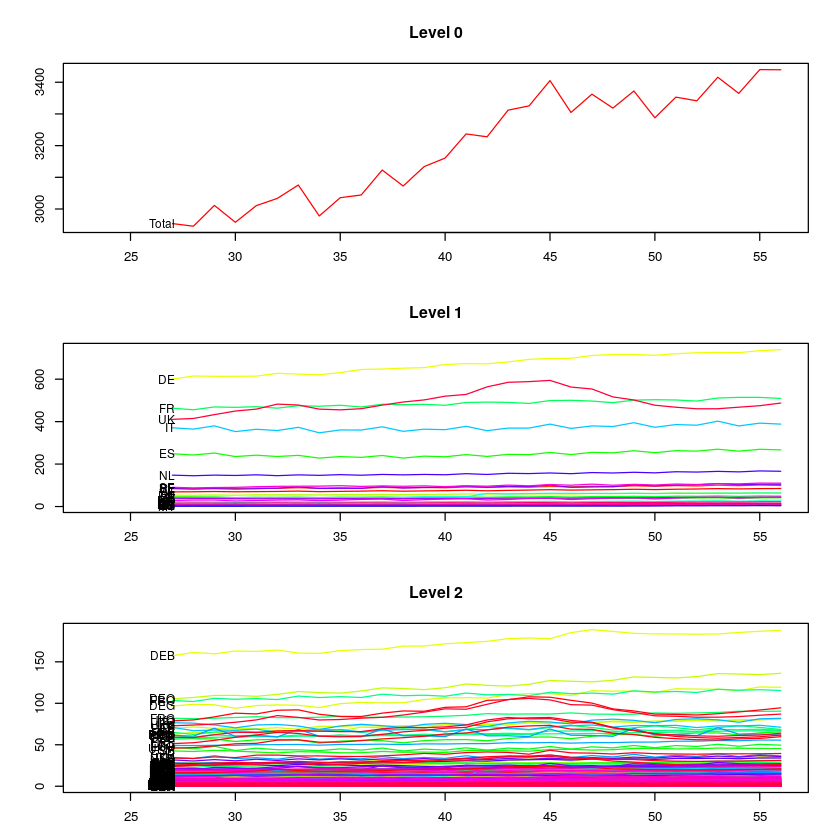

In [179]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5, characters = var_char)
plot(y_f5, levels = c(0, 1, 2), include = 30)

In [180]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,86.409621,0.8791445,-0.02089313,-0.8095359,-1.027785,1.738947,20.429866,0.04862349,-0.8368866,-0.1620919,⋯,0.7600803,11.08207,5.732651,7.835159,3.271404,-2.102235,9.816359,7.620617,2.883496,1.953432
RMSE,90.709593,1.0108940,0.29689804,0.9049042,1.127968,2.074521,22.533945,0.87923292,0.9228144,0.6090558,⋯,0.8038689,11.48393,5.971085,8.133038,3.448998,2.340960,10.263709,8.140523,4.012751,2.120936
MAE,86.409621,0.8791445,0.23820825,0.8095359,1.027785,1.738947,20.429866,0.69662838,0.8368866,0.5100542,⋯,0.7600803,11.08207,5.732651,7.835159,3.271404,2.102235,9.816359,7.620617,3.463137,1.953432
MAPE,2.484834,1.0423082,0.24215006,7.1673774,23.659767,3.823036,2.714768,1.09898507,15.8216791,1.2816135,⋯,22.1263765,14.98898,17.917554,8.405007,9.569124,5.741726,13.876817,11.516694,3.753251,8.762493
MPE,2.484834,1.0423082,-0.01896504,-7.1673774,-23.659767,3.823036,2.714768,0.08033434,-15.8216791,-0.4477034,⋯,22.1263765,14.98898,17.917554,8.405007,9.569124,-5.741726,13.876817,11.516694,3.124505,8.762493


In [181]:
var_acc_metrics  <-  c(1,2,5)

In [182]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
86.409621 90.709593  2.484834

In [183]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2970.881 3007.432 3009.293 3077.349 3049.435 3088.603 3093.974 3156.055
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3024.553 3070.477 3092.865 3134.418 3094.506 3140.511 3164.920 3205.988
Hierarchical Time Series 
3 Le

In [184]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [185]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [186]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [187]:
df_acc

ME,RMSE,MAPE,Iteration
-24.27503,39.11367,1.0288193,1
-17.91662,30.36804,0.8362184,5
57.98127,74.87051,1.7517469,9
61.35760,66.56714,1.8366534,13
-62.74753,70.72910,1.9165411,17
86.40962,90.70959,2.4848337,20


In [188]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

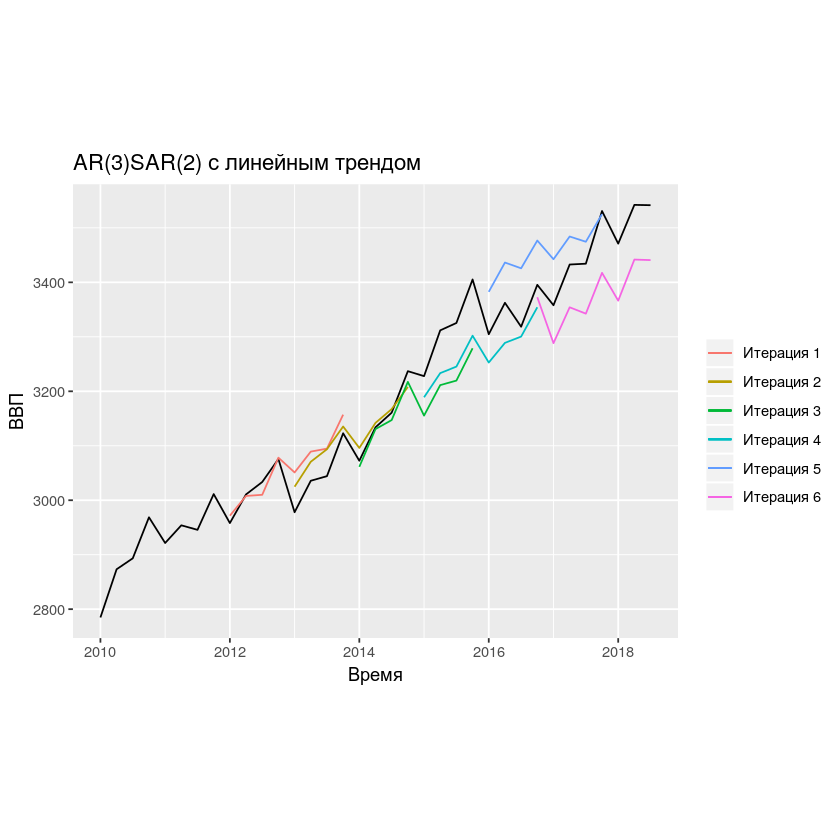

In [189]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [194]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
16.801551 62.059674  1.642469 10.833333

In [195]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [196]:
df_mean_acc[2,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),NA,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


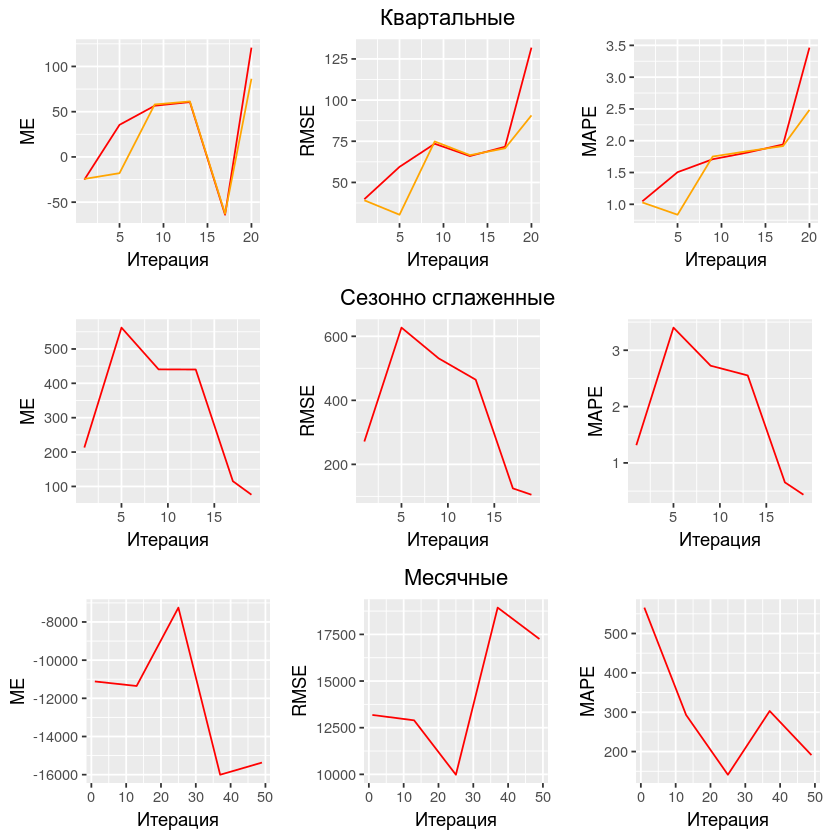

In [197]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)